# Getting Started with PyFixest

In a first step, we load the module and some example data:

In [12]:
%load_ext autoreload
%autoreload 2

from pyfixest.estimation import feols, fepois
from pyfixest.summarize import summary
from pyfixest.visualize import coefplot, iplot
from pyfixest.utils import get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
data = get_data()
data.head()

,Y,Y2,X1,X2,f1,f2,f3,group_id,Z1,Z2
0,NaN,-9.166216,2.0,0.457858,9.0,15.0,0.0,1.0,1.524607,-0.818696
1,3.221964,-2.835142,NaN,-4.998406,8.0,6.0,9.0,11.0,NaN,-5.650218
2,1.449755,-3.721375,1.0,1.558480,NaN,11.0,0.0,18.0,2.125211,0.656295
3,4.811894,14.328147,1.0,1.560402,15.0,1.0,4.0,15.0,0.903356,1.572646
4,1.193511,-6.568647,2.0,-3.472232,20.0,19.0,9.0,5.0,3.711146,-3.955593


## OLS Estimation

We can estimate a fixed effects regression via the `feols()` function. `feols()` has three arguments: a two-sided model formula, the data, and optionally, the type of inference.

In [14]:
fit = feols(fml="Y~X1 | f1", data=data, vcov="HC1")
type(fit)

Model:  Y~X1|f1


pyfixest.feols.Feols

The first part of the formula contains the dependent variable and "regular" covariates, while the second part contains fixed effects.

`feols()` returns an instance of the `Fixest` class, which supports a range of method to inspect results: 

To inspect the results, we can use a summary function or method:

In [15]:
fit.summary()

###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.056 |     6.276 |      0.000 |   0.240 |    0.458 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036


Alternatively, the `.summarize` module contains a `summary` function, which can be applied on instances of regression model objects 
or lists of regression model objects. 

In [16]:
summary(fit)

###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.056 |     6.276 |      0.000 |   0.240 |    0.458 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036


You can access individual elements of the summary via dedicated methods: `.tidy()` returns a "tidy" `pd.DataFrame`, 
`.coef()` returns estimated parameters, and `se()` estimated standard errors. Other methods include `pvalue()`, `confint()`
and `tstat()`.

In [17]:
fit.coef()

Coefficient
X1    0.34888
Name: Estimate, dtype: float64

In [18]:
fit.se()

Coefficient
X1    0.055591
Name: Std. Error, dtype: float64

## Standard Errors and Inference

Supported covariance types are "iid", "HC1-3", CRV1 and CRV3 (one-way clustering). Inference can be adjusted "on-the-fly" via the
`.vcov()` method:

In [19]:
fit.vcov({"CRV1": "group_id"}).summary()
fit.vcov("HC1").summary()

###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.070 |     4.985 |      0.000 |   0.202 |    0.496 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.056 |     6.276 |      0.000 |   0.240 |    0.458 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036


It is also possible to run a wild (cluster) bootstrap after estimation (via the [wildboottest module](https://github.com/s3alfisc/wildboottest), only for Python
versions smaller than `3.11`):

In [20]:
fit2 = feols(fml="Y~ csw(X1, X2)", data=data, vcov={"CRV1": "group_id"})
fit2.wildboottest(param="X1", B=999)

Model:  Y~X1


param                X1
statistic         4.351
pvalue              0.0
bootstrap_type       11
impose_null        True
dtype: object

Note that the wild bootstrap currently does not support fixed effects in the regression model. Supporting fixed effects is work in progress.

## IV Estimation 

It is also possible to estimate instrumental variable models with *one* endogenous variable and (potentially multiple) instruments:

In [21]:
iv_fit = feols(fml="Y2~ 1 | f1 + f2 | X1 ~ Z1 + Z2", data=data)
iv_fit.summary()

Model:  Y2~X1|f1+f2|X1~Z1+Z2
###

Model:  IV
Dep. var.:  Y2
Fixed effects:  f1+f2
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.397 |        0.335 |     1.185 |      0.246 |  -0.288 |    1.082 |
---


If the model does not contain any fixed effects, just drop the second part of the formula above:

In [22]:
feols(fml="Y~ 1 | X1 ~ Z1 + Z2", data=data).summary()

Model:  Y~X1|X1~Z1+Z2
###

Model:  IV
Dep. var.:  Y
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.306 |        0.121 |    19.014 |      0.000 |   2.068 |    2.544 |
| X1            |      0.260 |        0.106 |     2.449 |      0.015 |   0.052 |    0.468 |
---


IV estimation with multiple endogenous variables and multiple estimation syntax is currently not supported. The syntax is "depvar ~ exog.vars | fixef effects | endog.vars ~ instruments".

## Poisson Regression 

With version `0.8.4`, it is possible to estimate Poisson Regressions (not yet on PyPi): 

In [23]:
from pyfixest.utils import get_poisson_data

pois_data = get_poisson_data()
pois_fit = fepois(fml="Y~X1 | X2+X3+X4", data=pois_data, vcov={"CRV1": "X4"})
pois_fit.summary()

Model:  Y~X1|X2+X3+X4
###

Model:  Poisson
Dep. var.:  Y
Fixed effects:  X2+X3+X4
Inference:  CRV1
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.874 |        0.037 |    23.780 |      0.000 |   0.802 |    0.946 |
---
Deviance: 481157.824


## Multiple Estimation 

`PyFixest` supports a range of multiple estimation functionality: `sw`, `sw0`, `csw`, `csw0`, and multiple dependent variables. If multiple regression syntax is used, 
`feols()` and `fepois` returns an instance of a `FixestMulti` object, which essentially consists of a dicionary of `Fepois` or `Feols` instances.

In [24]:
multi_fit = feols(fml="Y~X1 | csw0(f1, f2)", data=data, vcov="HC1")
multi_fit

In [25]:
multi_fit.summary()

###

Model:  OLS
Dep. var.:  Y
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.260 |        0.093 |    24.242 |      0.000 |   2.077 |    2.443 |
| X1            |      0.305 |        0.070 |     4.348 |      0.000 |   0.167 |    0.443 |
---
RMSE: 1.764  Adj. R2: 0.017  Adj. R2 Within: 0.017
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.056 |     6.276 |      0.000 |   0.240 |    0.458 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1+f2
Inference:  HC1
Observations:  997

| Co

Alternatively, you can look at the estimation results via the `etable()` method:

In [26]:
multi_fit.etable()

fml              Y~X1        Y~X1|f1 Y~X1|f1+f2
Coefficient Intercept     X1      X1         X1
Estimate        2.260  0.305   0.349      0.344
Std. Error      0.093  0.070   0.056      0.047
t value        24.242  4.348   6.276      7.254
Pr(>|t|)        0.000  0.000   0.000      0.000
2.5 %           2.077  0.167   0.240      0.251
97.5 %          2.443  0.443   0.458      0.437

If you are only insterested in some parameters, e.g. "X1", you can use the following syntax:

In [27]:
multi_fit.etable().xs("X1", level=1, axis=1)

fml,Y~X1,Y~X1|f1,Y~X1|f1+f2
Estimate,0.305,0.349,0.344
Std. Error,0.070,0.056,0.047
t value,4.348,6.276,7.254
Pr(>|t|),0.000,0.000,0.000
2.5 %,0.167,0.240,0.251
97.5 %,0.443,0.458,0.437


You can access an individual model by its name - i.e. a formula - via the `all_fitted_models` attribure.

In [28]:
multi_fit.all_fitted_models["Y~X1"].tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,2.259754,0.093217,24.241742,0.000000,2.076828,2.442679
X1,0.305068,0.070155,4.348470,0.000015,0.167399,0.442737


or equivalently via the `fetch_model` method:

In [29]:
multi_fit.fetch_model(0).tidy()

Model:  Y~X1


,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,2.259754,0.093217,24.241742,0.000000,2.076828,2.442679
X1,0.305068,0.070155,4.348470,0.000015,0.167399,0.442737


Here, `0` simply fetches the first model stored in the `all_fitted_models` dictionary, `1` the second etc.

Objects of type `Fixest` come with a range of additional methods: `tidy()`, `coef()`, `vcov()` etc, which 
essentially loop over the equivalent methods of all fitted models. E.g. `Fixest.vcov()` updates inference for all 
models stored in `Fixest`.

In [30]:
multi_fit.vcov("iid").summary()

###

Model:  OLS
Dep. var.:  Y
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.260 |        0.090 |    25.218 |      0.000 |   2.084 |    2.436 |
| X1            |      0.305 |        0.069 |     4.417 |      0.000 |   0.170 |    0.441 |
---
RMSE: 1.764  Adj. R2: 0.017  Adj. R2 Within: 0.017
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1
Inference:  iid
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.349 |        0.056 |     6.219 |      0.000 |   0.239 |    0.459 |
---
RMSE: 1.422  Adj. R2: 0.036  Adj. R2 Within: 0.036
###

Model:  OLS
Dep. var.:  Y
Fixed effects:  f1+f2
Inference:  iid
Observations:  997

| Co

## TWFE Event Study

To conclude this intro, we estimate an event study from an example of the the [LOST](https://lost-stats.github.io/Model_Estimation/Research_Design/event_study.html) library of statistical techniques.

Model:  asmrs~i(time_to_treat,treat,ref=-1)+pcinc|stfips+year


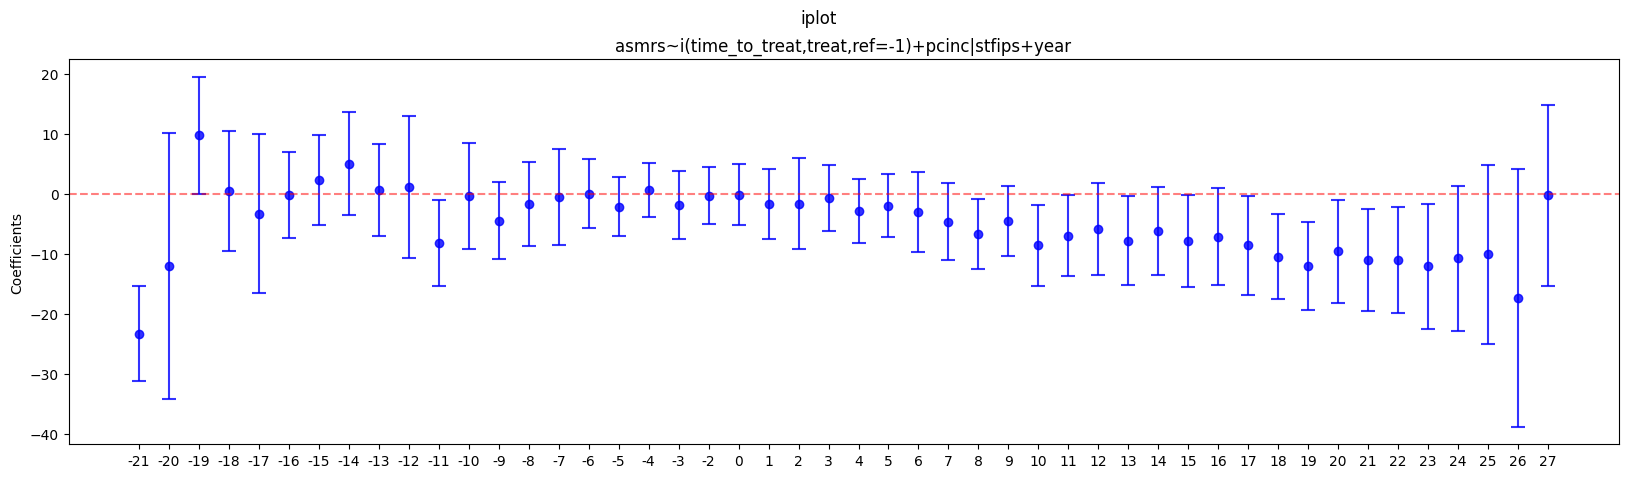

In [31]:
import pandas as pd
import numpy as np

# Read in data
df = pd.read_csv(
    "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
)

df["time_to_treat"] = (df["year"] - df["_nfd"]).fillna(0).astype(int)
df["time_to_treat"] = pd.Categorical(
    df.time_to_treat, np.sort(df.time_to_treat.unique())
)
df["treat"] = np.where(pd.isna(df["_nfd"]), 0, 1)

fml = "asmrs ~ i(time_to_treat, treat, ref = -1) + csw(pcinc, asmrh, cases) | stfips + year"
fit = feols(fml=fml, data=df, vcov={"CRV1": "stfips"})
fit.iplot(yintercept=0, figsize=(20, 5))